In [1]:
import pandas as pd
pd.set_option('max_columns',100)
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import time as time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTENC, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [4]:
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

# Pre-processing

1. Duration Column: Replace -1 by 0
2. Net Sales: Take absolute of -ve values, find the sqrt, and then add the -ve sign again.


In [16]:
df = pd.read_csv('../data/train.csv')

In [17]:
df[df['Net Sales'] < df['Commision (in value)']]

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
33,6138,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,4,THAILAND,0.0,17.82,30,0
62,5266,C2B,Airlines,Online,Bronze Plan,77,SINGAPORE,0.0,15.00,28,0
104,9734,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,81,UNITED KINGDOM,-128.7,77.22,63,0
120,3642,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,13,MALAYSIA,0.0,11.88,62,0
125,9233,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,26,GERMANY,0.0,47.52,39,0
...,...,...,...,...,...,...,...,...,...,...,...
52154,9527,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,196,AUSTRALIA,-69.3,41.58,66,0
52163,3711,EPX,Travel Agency,Online,Cancellation Plan,18,JAPAN,-45.0,0.00,54,0
52213,8297,JZI,Airlines,Online,Value Plan,70,UNITED STATES,0.0,25.55,118,0
52242,4079,EPX,Travel Agency,Online,Cancellation Plan,261,UNITED STATES,-80.0,0.00,71,0


In [18]:
df.drop('ID',1,inplace = True)

### Categorical Columns

1. Agency

In [19]:
df.head(3)

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,EPX,Travel Agency,Online,Cancellation Plan,61,PHILIPPINES,12.0,0.00,41,0
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,17.0,0.00,35,0
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,26,THAILAND,19.8,11.88,47,0


In [20]:
df['Total Sales'] = df['Net Sales'] + df['Commision (in value)']
df.drop(['Net Sales','Commision (in value)'],1,inplace=True)

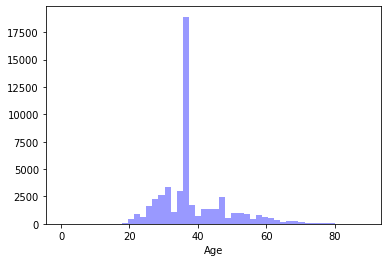

In [22]:
sns.distplot(df[df.Claim == 90].Age, color = 'coral', kde = False)
sns.distplot(df[df.Age <=90].Age, color = 'blue', kde = False)

In [23]:
df[df.Age > 90].Claim.value_counts(normalize = True)

0    0.901484
1    0.098516
Name: Claim, dtype: float64

In [24]:
df[df.Age <= 90].Claim.value_counts(normalize = True)

0    0.832322
1    0.167678
Name: Claim, dtype: float64

In [25]:
df.loc[:,'Age'] = df['Age'].apply(lambda x: 36 if x > 70 else x).values

In [26]:
countries = df.Destination.value_counts()[:30].index.tolist()
df.loc[:,'Destination'] = df['Destination'].apply(lambda x: 'OTHERS' if x not in countries else x)

In [27]:
columns = df.select_dtypes('object').columns.tolist()
for column in columns:
    df = pd.concat((df,pd.get_dummies(df[column])),1)
    df.drop(column,1,inplace = True)
df

,Duration,Age,Claim,Total Sales,ADM,ART,C2B,CBH,CCR,CSR,CWT,EPX,JWT,JZI,KML,LWC,RAB,SSI,TST,TTW,Airlines,Travel Agency,Offline,Online,1 way Comprehensive Plan,2 way Comprehensive Plan,24 Protect,Annual Gold Plan,Annual Silver Plan,Annual Travel Protect Gold,Annual Travel Protect Platinum,Annual Travel Protect Silver,Basic Plan,Bronze Plan,Cancellation Plan,Child Comprehensive Plan,Comprehensive Plan,Gold Plan,Individual Comprehensive Plan,Premier Plan,Rental Vehicle Excess Insurance,Silver Plan,Single Trip Travel Protect Gold,Single Trip Travel Protect Platinum,Single Trip Travel Protect Silver,Spouse or Parents Comprehensive Plan,Ticket Protector,Travel Cruise Protect,Value Plan,AUSTRALIA,BRUNEI DARUSSALAM,CAMBODIA,CANADA,CHINA,FRANCE,GERMANY,HONG KONG,INDIA,INDONESIA,ITALY,JAPAN,"KOREA, REPUBLIC OF",MALAYSIA,MYANMAR,NEPAL,NETHERLANDS,NEW ZEALAND,OTHERS,PHILIPPINES,SINGAPORE,SOUTH AFRICA,SPAIN,SRI LANKA,SWITZERLAND,"TAIWAN, PROVINCE OF CHINA",THAILAND,UNITED ARAB EMIRATES,UNITED KINGDOM,UNITED STATES,VIET NAM
0,61,41,0,12.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,4,35,0,17.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26,47,0,31.680000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,15,48,0,27.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15,36,0,37.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52305,365,40,1,555.936394,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
52306,8,54,0,32.200000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52307,38,37,0,76.380000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
52308,2,46,0,10.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [28]:
# Treating negative values in Duration column
df.Duration.replace(-1,0, inplace = True)
df.Duration.replace(-2,0, inplace = True)

### Managing Skewed columns

In [29]:
df.loc[:,'Duration'] = np.power(df.Duration, 0.15)

In [30]:
# Transforming values in Net Sales column
power = 0.25
values = df.index
for index in values:
    if df.loc[index,'Total Sales'] < 0:
        df.loc[index,'Total Sales'] = -np.power(abs(df.loc[index,'Total Sales']), power)
    else:
        df.loc[index,'Total Sales'] = np.power(df.loc[index,'Total Sales'], power)

In [35]:
#df.loc[:,'Commision (in value)'] = np.power(df['Commision (in value)'], 0.3)

In [36]:
df

,Duration,Age,Claim,Total Sales,ADM,ART,C2B,CBH,CCR,CSR,CWT,EPX,JWT,JZI,KML,LWC,RAB,SSI,TST,TTW,Airlines,Travel Agency,Offline,Online,1 way Comprehensive Plan,2 way Comprehensive Plan,24 Protect,Annual Gold Plan,Annual Silver Plan,Annual Travel Protect Gold,Annual Travel Protect Platinum,Annual Travel Protect Silver,Basic Plan,Bronze Plan,Cancellation Plan,Child Comprehensive Plan,Comprehensive Plan,Gold Plan,Individual Comprehensive Plan,Premier Plan,Rental Vehicle Excess Insurance,Silver Plan,Single Trip Travel Protect Gold,Single Trip Travel Protect Platinum,Single Trip Travel Protect Silver,Spouse or Parents Comprehensive Plan,Ticket Protector,Travel Cruise Protect,Value Plan,AUSTRALIA,BRUNEI DARUSSALAM,CAMBODIA,CANADA,CHINA,FRANCE,GERMANY,HONG KONG,INDIA,INDONESIA,ITALY,JAPAN,"KOREA, REPUBLIC OF",MALAYSIA,MYANMAR,NEPAL,NETHERLANDS,NEW ZEALAND,OTHERS,PHILIPPINES,SINGAPORE,SOUTH AFRICA,SPAIN,SRI LANKA,SWITZERLAND,"TAIWAN, PROVINCE OF CHINA",THAILAND,UNITED ARAB EMIRATES,UNITED KINGDOM,UNITED STATES,VIET NAM
0,1.852676,41,0,1.861210,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1.231144,35,0,2.030543,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.630219,47,0,2.372446,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1.501114,48,0,2.279507,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.501114,36,0,2.466326,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52305,2.422947,40,1,4.855750,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
52306,1.366040,54,0,2.382122,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52307,1.725709,37,0,2.956276,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
52308,1.109569,46,0,1.778279,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [31]:
t0 = time.time()
X = df.drop('Claim',1)
y = df.Claim

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0, test_size = 0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(random_state = 0)

model.fit(X_train, y_train)

pred = model.predict(X_test)

t1 = time.time()

print('Time Taken:', t1-t0)
print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))
print('Confusion Matrix:', confusion_matrix(y_test, pred))

Time Taken: 11.446740865707397
Accuracy: 0.9308927547314089
Precision: 0.802498512790006
Recall: 0.7752873563218391
Confusion Matrix: [[8390  332]
 [ 391 1349]]


In [ ]:
Time Taken: 6.445984125137329
Accuracy: 0.9329956031351558
Precision: 0.809042236763831
Recall: 0.7816091954022989
Confusion Matrix: [[8401  321]
 [ 380 1360]]

In [32]:
t0 = time.time()
X = df.drop('Claim',1)
y = df.Claim

sm = RandomOverSampler(random_state=0)
X_res, y_res = sm.fit_resample(X, y)

X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,random_state = 0, test_size = 0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(random_state = 0, criterion = 'entropy')

model.fit(X_train, y_train)

pred = model.predict(X_test)

t1 = time.time()

print('Time Taken:', t1-t0)
print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))
print('Confusion Matrix:', confusion_matrix(y_test, pred))

Time Taken: 23.91620445251465
Accuracy: 0.9747648543243863
Precision: 0.952191235059761
Recall: 0.9990710636321412
Confusion Matrix: [[4196  216]
 [   4 4302]]


In [ ]:
Time Taken: 13.941442012786865
Accuracy: 0.9745354439091535
Precision: 0.9517699115044248
Recall: 0.9990710636321412
Confusion Matrix: [[4194  218]
 [   4 4302]]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


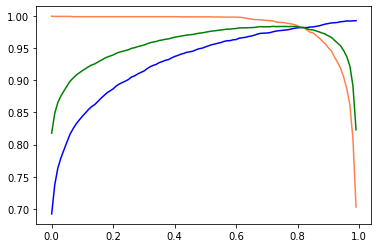

In [33]:
precision = []
recall = []
f1score = []
for threshold in tqdm(np.array(range(100))/100):
    predictions = model.predict_proba(X_test)[:,1]
    predictions = (predictions > threshold).astype(int)
    
    precision.append(precision_score(y_test, predictions))
    recall.append(recall_score(y_test, predictions)) 
    f1score.append(f1_score(y_test, predictions))

sns.lineplot(x = np.array(range(100))/100, y = precision, color = 'blue')
sns.lineplot(x = np.array(range(100))/100, y = recall,color = 'coral')
sns.lineplot(x = np.array(range(100))/100, y = f1score,color = 'green')

In [34]:
predictions = model.predict_proba(X_test)[:,1]
predictions = (predictions > 0.98).astype(int)

print(precision_score(y_test, predictions))
print(recall_score(y_test, predictions))
print(f1_score(y_test, predictions))
print(accuracy_score(y_test, predictions))

0.9928714000570288
0.8086391082210869
0.8913349545629081
0.9026152787336545


In [ ]:
0.9931740614334471
0.8109614491407339
0.8928662746100741
0.9038770360174352

In [35]:
predictions = model.predict_proba(X_test)[:,1]
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98]

for threshold in thresholds:
    pred = (predictions > threshold).astype(int)
    print('='*40)
    print('Threshold Value: ', threshold)
    print('Precision Score: ',precision_score(y_test, pred))
    print('Recall Score: ', recall_score(y_test, pred))
    print('F1 Score: ', f1_score(y_test, pred))
    print('Accuracy Score: ', accuracy_score(y_test, pred))
    print('='*40)

Threshold Value:  0.5
Precision Score:  0.952191235059761
Recall Score:  0.9990710636321412
F1 Score:  0.9750679963735267
Accuracy Score:  0.9747648543243863
Threshold Value:  0.6
Precision Score:  0.9636934110264456
Recall Score:  0.9986065954482118
F1 Score:  0.9808394160583942
Accuracy Score:  0.9807295251204404
Threshold Value:  0.7
Precision Score:  0.9738219895287958
Recall Score:  0.9934974454249884
F1 Score:  0.983561328888378
Accuracy Score:  0.9835971553108511
Threshold Value:  0.8
Precision Score:  0.9819444444444444
Recall Score:  0.9851370181142591
F1 Score:  0.9835381405054485
Accuracy Score:  0.9837118605184675
Threshold Value:  0.9
Precision Score:  0.9886500845206472
Recall Score:  0.9507663725034835
F1 Score:  0.9693382265893218
Accuracy Score:  0.9702913512273457
Threshold Value:  0.95
Precision Score:  0.9918533604887984
Recall Score:  0.9047840222944729
F1 Score:  0.9463201360213748
Accuracy Score:  0.9493002982335398
Threshold Value:  0.98
Precision Score:  0.9928

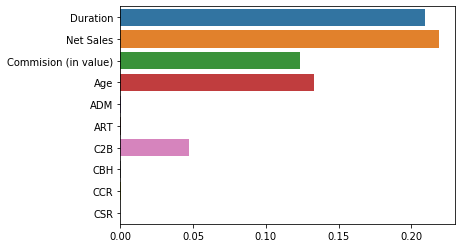

In [36]:
sns.barplot(x = model.feature_importances_[:10], y = X.columns[:10])

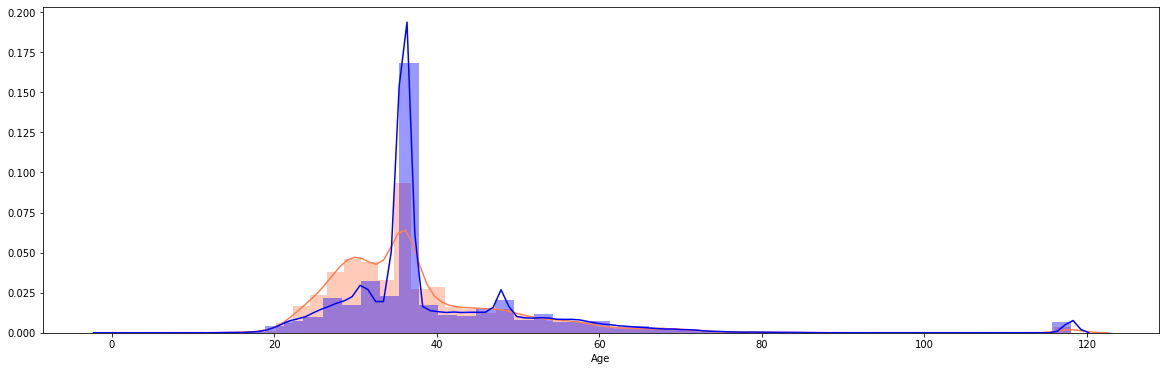

In [38]:
plt.figure(figsize = (20,6))
sns.distplot(df[df.Claim == 1].Age, color = 'coral')
sns.distplot(df[df.Claim == 0].Age, color = 'blue')

In [85]:
test = pd.read_csv('data/test.csv')
ids = test.ID

### Transforming Test Data

In [86]:
# Drop ID
test.drop('ID',1,inplace = True)

#Categorical Columns
countries = test.Destination.value_counts()[:30].index.tolist()
test.loc[:,'Destination'] = test['Destination'].apply(lambda x: 'OTHERS' if x not in countries else x)

# One Hot Encoding
columns = test.select_dtypes('object').columns.tolist()
for column in columns:
    test = pd.concat((test,pd.get_dummies(test[column])),1)
    test.drop(column,1,inplace = True)

# Treating negative values in Duration column
test.Duration.replace(-1,0, inplace = True)
test.Duration.replace(-2,0, inplace = True)

# Skewed Columns
test.loc[:,'Duration'] = np.power(test.Duration, 0.15)

power = 0.25
values = test.index
for index in values:
    if test.loc[index,'Net Sales'] < 0:
        test.loc[index,'Net Sales'] = -np.power(abs(test.loc[index,'Net Sales']), power)
    else:
        test.loc[index,'Net Sales'] = np.power(test.loc[index,'Net Sales'], power)       

test.loc[:,'Commision (in value)'] = np.power(test['Commision (in value)'], 0.3)

# Scaler tranformation
test = scaler.transform(test)

# prediction
pred_test = model.predict(test)

# threshold tuned predictions 
predictions = model.predict_proba(test)[:,1]
predictions = (predictions > 0.98).astype(int)

In [87]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [88]:
submission = pd.DataFrame()
submission['ID'] = ids
submission['Claim'] = predictions

submission

,ID,Claim
0,17631,0
1,15064,0
2,14139,0
3,19754,0
4,16439,0
...,...,...
22416,13227,0
22417,12767,0
22418,13638,0
22419,14859,0


In [89]:
submission.to_csv('submission_2.csv',index = False)